# App review classification using Convolutional Neural Network

### Import the necessary libraries

In [12]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import mlflow
import mlflow.keras
from matplotlib import pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, MaxPooling1D
import itertools
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

### Load the Dataset

In [13]:
df = pd.read_csv('randomized_balanced.csv')
df.head()

,review,label
0,Seems more transparent & meaningful issues.,rating
1,The best app for editing texts,rating
2,It seems like it would be a great addition to ...,feature request
3,Its really fun and any age can play it and enj...,user experience
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report


## Start of Preprocessing

In [14]:
df['count'] = df['review'].apply(lambda x: len(x.split()))# add a column for the number of words in the review
df.head()

,review,label,count
0,Seems more transparent & meaningful issues.,rating,6
1,The best app for editing texts,rating,6
2,It seems like it would be a great addition to ...,feature request,27
3,Its really fun and any age can play it and enj...,user experience,20
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report,43


### Get the number of word distrubution in the dataset

<Figure size 800x800 with 0 Axes>

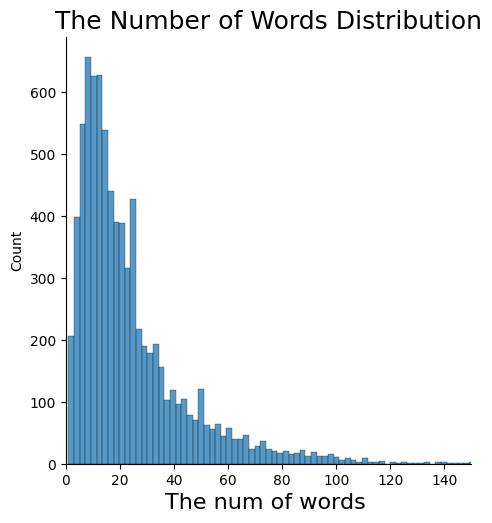

In [15]:
plt.figure(figsize= (8, 8))

sns.displot(df['count'])

plt.xlim(0, 150)

plt.xlabel('The num of words ', fontsize = 16)
plt.title("The Number of Words Distribution", fontsize = 18)
plt.show()

### Assign a Unique Integer for each target Class

In [16]:
df['encoded_text'] = df['label'].astype('category').cat.codes # encode the class labels
df.head(10)

,review,label,count,encoded_text
0,Seems more transparent & meaningful issues.,rating,6,2
1,The best app for editing texts,rating,6,2
2,It seems like it would be a great addition to ...,feature request,27,1
3,Its really fun and any age can play it and enj...,user experience,20,3
4,"Hey whatsApp , atomic_number_53 am experiancin...",bug report,43,0
5,Good app really really Best app Thanks Faceboo...,rating,9,2
6,I think we should get more.,feature request,6,1
7,No option for dark mode on my Motorola g5 stylus,feature request,10,1
8,atomic_number_53 gave it a 4 star because I co...,bug report,19,0
9,"Not what it use to be, too many ads. Not enoug...",user experience,47,3


In [17]:
# Split the data into training, validation, and testing sets
train_data, temp_data, train_labels, temp_labels = train_test_split(df['review'], df['encoded_text'], test_size=0.5, random_state=0)
val_data, test_data, val_labels, test_labels = train_test_split(temp_data, temp_labels, test_size=0.5, random_state=0)

### Initialize the Tokenizer and tokenize the dataset

In [18]:
# Adjust the max words and max length for the Tokenizer
max_words = 10000 
max_len = 128      

# Initialize the Tokenizer
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_data)

# Convert the text data to sequence using the Tokenizer
train_sequences = tokenizer.texts_to_sequences(train_data)
val_sequences = tokenizer.texts_to_sequences(val_data)
test_sequences = tokenizer.texts_to_sequences(test_data)

# Pad the sequence data to the defined max length
train_padded = pad_sequences(train_sequences, maxlen=max_len, padding='post')
val_padded = pad_sequences(val_sequences, maxlen=max_len, padding='post')
test_padded = pad_sequences(test_sequences, maxlen=max_len, padding='post')

## Define the Convolutional Neural Network Model

In [19]:
def create_model(embedding_dim, num_filters, kernel_size, dropout_rate): # create a function to build the model with the hyperparameters
    model = Sequential() # create a sequential model
    model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len)) # add an embedding layer 
    model.add(Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu')) # add a 1D convolutional layer with relu activation
    model.add(GlobalMaxPooling1D()) # add a global max pooling layer
    model.add(Dropout(dropout_rate)) # add a dropout layer
    model.add(Dense(4, activation='softmax')) # add a dense layer with softmax activation

    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy']) # compile the model with adam optimizer, sparse categorical crossentropy loss, and accuracy metric
    return model


### Hyperparameter selection

In [20]:
# Define the hyperparameters
embedding_output_dim = [50, 100, 200] # the output dimension of the embedding layer
num_filters = [32,64, 128] # the number of filters in the convolutional layer
kernel_size = [5,7] # the kernel size in the convolutional layer
dropout_rate = [0.2, 0.5] # the dropout rate

hyperparameter_configs = []

#Create and append all possible hyperparameter configurations into the list
hyperparameter_configs = list(itertools.product(embedding_output_dim, num_filters, kernel_size, dropout_rate))

## Training and Evaluation of the Model using MLflow

In [21]:
# Main loop to train the model with each hyperparameter configuration
def train_model(params):
    embedding_dim, num_filters, kernel_size, dropout_rate = params
    mlflow.set_experiment("CNN-final")  # Set the experiment name to be used in MLflow
    with mlflow.start_run(experiment_id=mlflow.get_experiment_by_name("CNN-final").experiment_id): # Start a new MLflow run

        # Log the hyperparameters
        mlflow.log_param("embedding_dim", embedding_dim) 
        mlflow.log_param("num_filters", num_filters)
        mlflow.log_param("kernel_size", kernel_size)
        mlflow.log_param("dropout_rate", dropout_rate)

        # Initialize the defined model with the hyperparameter configuration
        model = create_model(embedding_dim, num_filters, kernel_size, dropout_rate)

        # Log the model summary and architecture into MLflow
        model_summary = []
        model.summary(print_fn=lambda x: model_summary.append(x))
        model_summary = '\n'.join(model_summary)
        mlflow.log_text(model_summary, "model_summary.txt")

        # Train the model with the training data and validate with the validation data
        model.fit(train_padded, train_labels, epochs=5, batch_size= 8,validation_data=(val_padded, val_labels))


        # Log the losses and accuracies into MLflow
        train_loss = model.history.history['loss'][-1] 
        train_acc = model.history.history['accuracy'][-1] 
        val_loss = model.history.history['val_loss'][-1]
        val_acc = model.history.history['val_accuracy'][-1]

        mlflow.log_metric("train_loss", train_loss)
        mlflow.log_metric("train_acc", train_acc)
        mlflow.log_metric("val_loss", val_loss)
        mlflow.log_metric("val_acc", val_acc)

        # Evaluate the model with the testing data
        test_loss, test_acc = model.evaluate(test_padded, test_labels)
        print(f'Test Loss: {test_loss}, Test Accuracy: {test_acc}') # print the test loss and accuracy

        # Predict the labels of the testing data
        predictions = model.predict(test_padded)
        predicted_labels = predictions.argmax(axis=1)

        # Calculate the accuracy, precision, recall, and F1 score
        accuracy = accuracy_score(test_labels, predicted_labels)
        precision = precision_score(test_labels, predicted_labels, average="macro")
        recall = recall_score(test_labels, predicted_labels, average="macro")
        f1 = f1_score(test_labels, predicted_labels, average="macro")

        # Display metrics
        print(f'Accuracy: {accuracy*100:.2f}%')
        print('\nPrecision:')
        print(precision)
        print('\nRecall:')
        print(recall)
        print('\nF1 Score:')
        print(f1)

        # Log metrics into MLflow
        mlflow.log_metric("Test Loss" , test_loss)
        mlflow.log_metric("Accuracy" , accuracy)
        mlflow.log_metric("Precision" , precision)
        mlflow.log_metric("Recall" , recall)
        mlflow.log_metric("F1 Score" , f1)

In [22]:
# Train the model with each hyperparameter configuration
for config in hyperparameter_configs:
    train_model(config)

2024/02/24 02:45:04 INFO mlflow.tracking.fluent: Experiment with name 'CNN-final' does not exist. Creating a new experiment.




Epoch 1/5


500/500 [==============================] - 2s 3ms/step - loss: 1.2431 - accuracy: 0.4697 - val_loss: 0.9725 - val_accuracy: 0.6645
Epoch 2/5
500/500 [==============================] - 1s 3ms/step - loss: 0.7405 - accuracy: 0.7385 - val_loss: 0.7106 - val_accuracy: 0.7440
Epoch 3/5
500/500 [==============================] - 1s 3ms/step - loss: 0.4137 - accuracy: 0.8712 - val_loss: 0.6114 - val_accuracy: 0.7780
Epoch 4/5
500/500 [==============================] - 1s 3ms/step - loss: 0.2464 - accuracy: 0.9268 - val_loss: 0.5824 - val_accuracy: 0.8005
Epoch 5/5
63/63 [==============================] - 0s 1ms/step - loss: 0.5350 - accuracy: 0.8265
Test Loss: 0.5349541902542114, Test Accuracy: 0.8264999985694885
63/63 [==============================] - 0s 1ms/step
Accuracy: 82.65%

Precision:
0.8271379633621121

Recall:
0.8267517899433077

F1 Score:
0.8261633537153561
Epoch 1/5
500/500 [==============================] - 2s 3ms/step - loss: 1.3007 - accuracy: 0.4103 - val_loss: 